# Thesis Fig.4.2: Box plots of estimated variances for Gaussian toy example

In [2]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [3]:
print(torch.__version__)

1.11.0


In [4]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [5]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())


file = 'toy_example_maf_03_05'


os.chdir('results/{}'.format(file))




### loads results file with NIPE without ratio
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')


file = 'toy_example_maf_03_05_ratio'



os.chdir('/home/ubuntu/results/{}'.format(file))

### loads results file with NIPE with ratio

list_collection_inc_ratio = torch.load('list_collection_inc.pt')



/home/ubuntu


In [6]:
def Gaussian(thetas, normal_noise=1):

    gauss_list = []

    for theta in thetas:

        mu, sigma = theta, normal_noise  # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)

        gauss_list.append(s[0])

    gauss_obs = torch.tensor(gauss_list)

    return gauss_obs

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.033
acceptance rate:  0.029
acceptance rate:  0.030666666666666665
acceptance rate:  0.031580645161290326
acceptance rate:  0.031073170731707317


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.035
acceptance rate:  0.029545454545454545
acceptance rate:  0.028904761904761905
acceptance rate:  0.028774193548387096
acceptance rate:  0.029
tensor([3.9110, 4.4465, 3.7563, 4.3569, 4.0340, 2.3900, 3.0279, 3.2241, 3.7405,
        3.0264, 3.7503, 2.8835, 2.5012, 3.6156, 2.9635])
tensor([ 7.3566, 10.3295, 20.6203, 11.9323, 86.5239, 56.2248, 24.4082, 28.0452,
         6.6460, 70.7210,  6.6152, 68.6577, 97.0487, 42.1511, 44.1058])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.2740, 17.2659,  5.4239,  9.3865, 12.2832,  2.2347,  6.3350,  4.0731,
          8.6770,  3.2321,  6.5151,  6.1300,  3.6150,  7.0644,  3.2047]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.223
acceptance rate:  0.22018181818181817


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.218
acceptance rate:  0.21363636363636362
tensor([4.5726, 4.3747, 3.2889, 3.7552, 4.6058, 1.8183, 3.0487, 3.4111, 4.1489,
        3.3004, 4.1906, 1.9152, 3.5121, 2.5787, 2.3701])
tensor([11.9492, 11.0668, 26.2315, 13.5846, 89.8481, 55.7939, 29.1537, 27.8350,
        11.1418, 65.1136,  7.2996, 62.6840, 95.1228, 39.7465, 45.7165])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[48.4780, 20.4293, 23.1337, 11.6523,  8.5909,  0.8703,  5.3517,  4.4393,
         32.1868, 15.6905,  9.4918,  6.1821, 11.9276,  1.9097,  1.7025]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.199
acceptance rate:  0.19081818181818183


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.18
acceptance rate:  0.1940909090909091
tensor([5.1882, 3.7794, 4.1731, 4.5315, 4.3449, 2.0968, 3.3521, 3.1946, 4.6111,
        3.0147, 3.9669, 2.6287, 5.3342, 2.4629, 2.5777])
tensor([11.5650,  5.8577, 28.7599, 14.2802, 84.6688, 57.3439, 26.9399, 28.2792,
        11.0799, 66.4387,  7.5556, 63.8513, 87.4163, 41.2331, 44.5256])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[47.9921,  5.3226, 45.1462, 17.4161, 21.6806,  3.7049,  3.9104,  4.2594,
         33.6654,  9.2821,  9.2555,  4.2971, 79.1438,  2.3919,  1.9879]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.038
acceptance rate:  0.036272727272727276
acceptance rate:  0.03495238095238095
acceptance rate:  0.03506451612903226


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.026
acceptance rate:  0.03736363636363636
acceptance rate:  0.03676190476190476
acceptance rate:  0.03512903225806452
tensor([5.0905, 4.3609, 3.2924, 4.3047, 4.4085, 2.3157, 3.0536, 3.4235, 3.0628,
        2.1269, 3.4814, 2.2921, 4.4450, 2.7459, 2.7274])
tensor([11.7953, 10.8329, 24.9895, 11.9937, 87.8605, 53.5164, 31.0052, 31.6066,
         4.6941, 67.8521,  7.8931, 62.3738, 93.4797, 40.5184, 44.6906])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[49.5075, 19.2146, 16.1759,  9.2928, 10.0226,  2.4420, 11.0667, 14.7400,
          3.3119,  3.3139,  8.4978,  7.8721, 23.1243,  2.3941,  2.2639]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.117
acceptance rate:  0.11454545454545455


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.105
acceptance rate:  0.11227272727272727
tensor([4.8396, 3.0363, 4.4124, 4.2835, 4.0465, 2.9134, 3.6948, 3.2319, 4.0157,
        2.8310, 6.9570, 2.8235, 4.7729, 2.0798, 2.8697])
tensor([10.3465,  5.0664, 25.9904, 14.7067, 85.2756, 56.2116, 27.9528, 29.1672,
         7.5712, 70.6460, 12.2531, 65.1407, 93.0785, 40.3809, 41.6952])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[36.6197,  3.4348, 25.6929, 18.2957, 17.4493,  3.4085,  5.4729,  5.8978,
         12.5492,  2.6753, 48.0637,  2.8173, 26.8593,  1.0031,  8.0243]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list_nipe = []

mean_list_nipe = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_nipe.append(var_x)
        mean_list_nipe.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [14]:
analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list_ratio = []

variance_list_ratio = []

mean_list_ratio = []

for posterior_incremental_list in list_collection_inc_ratio:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        #posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list_ratio.append(var_x)
        mean_list_ratio.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list_ratio.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  1.0


In [15]:


nipe_array = torch.stack(([variance_list_nipe[i] for i in range(5)]), dim=1)

snpe_array = torch.stack(([variance_list_snpe[i] for i in range(5)]), dim=1)


nipe_ratio_array = torch.stack(([variance_list_ratio[i] for i in range(5)]), dim=1)



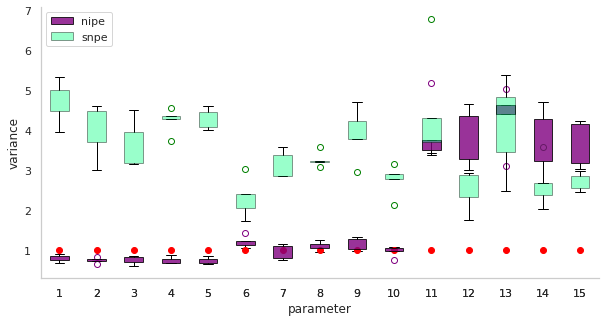

In [17]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('talk')
sns.set_context('notebook')


figure_mosaic = """
C
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(10, 5))

nipe = axes['C'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
                  )



#nipe = axes['A'].boxplot(nipe_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='purple', markeredgecolor='purple', label='nipe'),
#                 )


snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green', label='snpe'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
for b in nipe['boxes']:
    b.set_alpha(0.8)
    
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
    


axes['C'].legend([nipe['boxes'][0], snpe_c['boxes'][0]], ['nipe', 'snpe'], loc='upper left')

axes['C'].set_xlabel('parameter')
axes['C'].set_ylabel('variance')


#axes['A'].legend([nipe['boxes'][0]], [ 'nipe'], loc='upper left')
sns.despine()
sns.set_context('notebook')

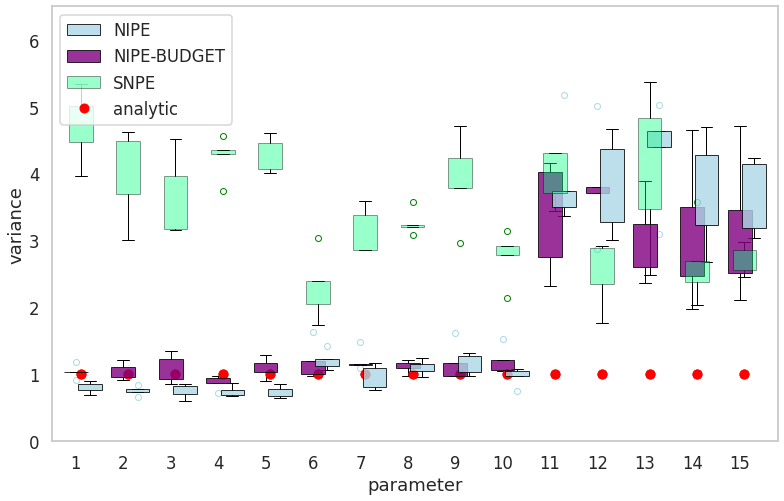

In [19]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
#sns.set_context('notebook')

figure_mosaic = """
ACC
BCC
"""

figure_mosaic = """
C
"""



fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(13, 8))




nipe_box = axes['C'].boxplot(nipe_ratio_array, patch_artist=True, medianprops = dict(linewidth=0), boxprops=dict(facecolor='purple'),  flierprops=dict(color='lightblue', markeredgecolor='lightblue'),
                  positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, 11.9, 12.9, 13.9, 
                                                                                 14.9])


nipe = axes['C'].boxplot(nipe_array, medianprops = dict(linewidth=0),patch_artist=True, boxprops=dict(facecolor='lightblue'),            
            flierprops=dict(color='lightblue', markeredgecolor='lightblue'),positions=[1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 
                                                                                 14.2, 15.2])

for b in nipe['boxes']:
    b.set_alpha(0.8)
    

    
#for b in nipe_ratio_box['boxes']:
#    b.set_alpha(0.8)

for b in nipe_box['boxes']:
    b.set_alpha(0.8)
    
#for b in snpe_box['boxes']:
#    b.set_alpha(0.4)
    
    
axes['C'].set(xticklabels=[])

ana_plot = axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

    
#axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='red', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_c = axes['C'].boxplot(snpe_array, patch_artist=True, medianprops = dict(linewidth=0),
                  boxprops=dict(facecolor='springgreen'), flierprops=dict(color='springgreen', markeredgecolor='green'),
                  )

for b in snpe_c['boxes']:
    b.set_alpha(0.4)
    
axes['C'].set_ylim(0,6.5)

axes['C'].legend()

axes['C'].set_xlabel('parameter')
axes['C'].set_ylabel('variance')

#axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
#axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe budget1',  'analytic'], loc='upper left')
axes['C'].legend([nipe['boxes'][0],  nipe_box['boxes'][0], snpe_c['boxes'][0], ana_plot[0]], ['NIPE', 'NIPE-BUDGET',  'SNPE', 'analytic'], loc='upper left')

In [23]:
nipe_array = torch.stack(([mean_list_nipe[i] for i in range(5)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(5)]), dim=1)

In [24]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

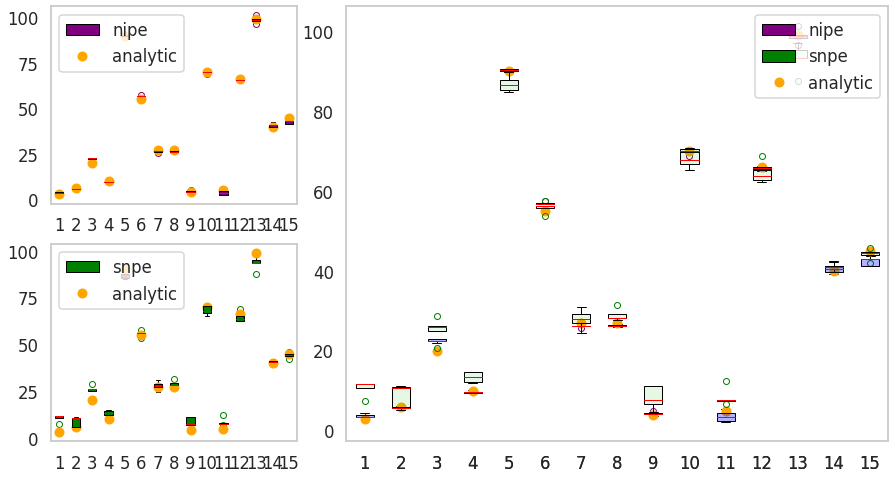

In [25]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(color='red'),            
            flierprops=dict(color='purple', markeredgecolor='purple'))

#[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

#[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='purple'), medianprops=dict(color='red'), flierprops=dict(color='purple', markeredgecolor='purple'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')